# Análisis de Series Temporales
## Primer Trabajo

#### Autores
 * TODO

In [1]:
rm(list = ls())
options(repr.plot.width=10, repr.plot.height=6)

In [2]:
library(magrittr)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(latex2exp)
require(reshape2)
library(forecast)

Loading required package: reshape2


In [3]:
lags <- 32

In [4]:
range_mean <- function(x, seasonality = 12) {
    n <- length(x)
    seq(1, n, by=seasonality) %>%
    sapply(function(i){
        a <- x[i:(i+seasonality)]
        c(mean=mean(a, na.rm=TRUE), range=diff(range(a,na.rm=TRUE)))
    }) %>%
    t() %>%
    as.data.frame()
} 

In [5]:
correlogram <- function(x, n = length(x) - 1, with.first = FALSE) {
    result <- acf(x, lag.max=n, plot=FALSE)$acf[1:n + !with.first]
    data.frame(lag = 1:length(result), values = result)
}

In [6]:
periodogram <- function(x) {
    result <- TSA::periodogram(x, plot=FALSE)
    data.frame(freq = c(0, result$freq), spec = c(0, result$spec))
}

In [7]:
plot.serie <- function(df, stationality, armonics = c()){
    p.a <- ggplot(df) + 
        aes(x = index, y = values) + 
        geom_line() 

    p.b <- ggplot(range_mean(df$values, stationality)) + 
        aes(x = mean, y = range) + 
        geom_point(size=3) + 
        expand_limits(y=0)

    p.c <- ggplot(correlogram(df$values, lags)) + 
        aes(x = lag, y = values) + 
        geom_bar(stat="identity") +
        geom_hline(yintercept = 2/sqrt(nrow(df)), color = "red") +
        geom_hline(yintercept = -2/sqrt(nrow(df)), color = "red")

    p.d <- ggplot(periodogram(df$values)) + 
        aes(x = freq, y = spec) + 
        geom_line()
    
    for (a in armonics) {
        p.d <- p.d + geom_vline(xintercept = a, color = "red", alpha = 0.4)
    }
    cowplot::plot_grid(p.a, p.b, p.c, p.d)
}

\setcounter{section}{1}

# Localización archivos de datos: Carpeta *datos* para T1 en el tema 2 del Campus Virtual.

## Describir la serie (plot de la serie, observaciones atípicas, plot rango-media, periodograma de la serie y de la diferenciada regularmente, correlograma de la serie y de la diferenciada regularmente, seasonal subseries plot, cualquier gráfico que ayude a entender la serie).

In [8]:
activos <- read.csv("./../data/activos.csv")
colnames(activos) <- c("values")
activos$index <- seq(as.Date("1976/10/01"), by = "3 months", 
                     length.out = nrow(activos))

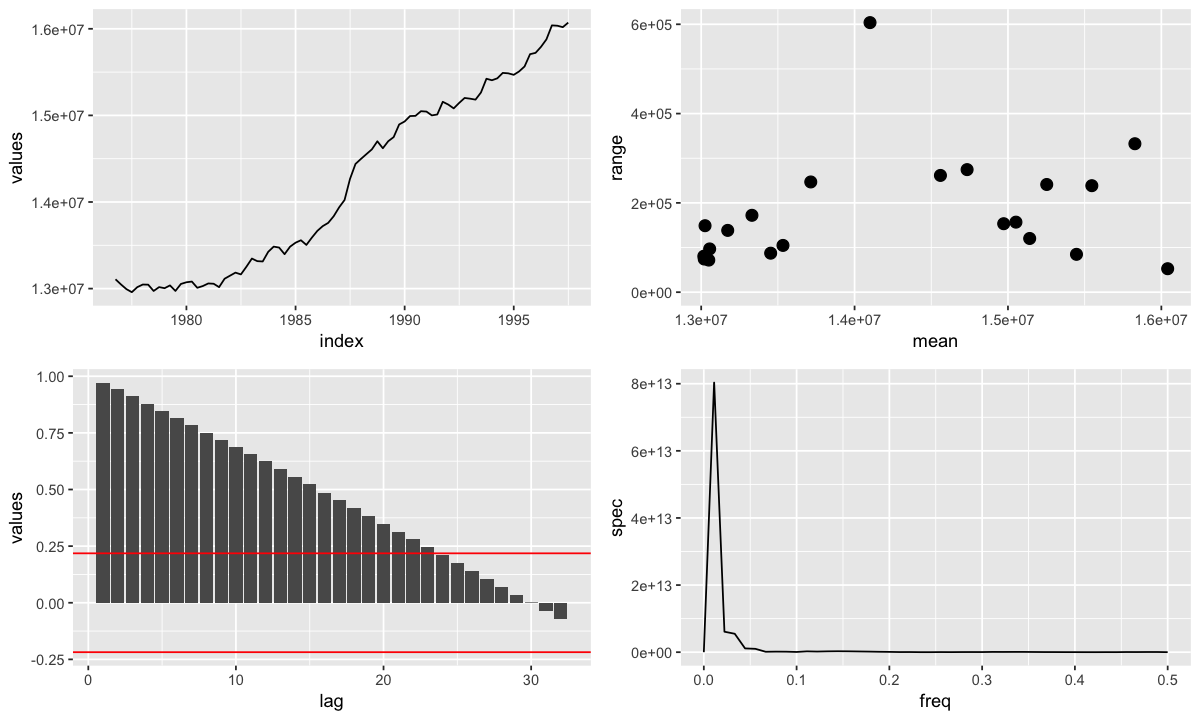

In [9]:
plot.serie(activos, stationality = 4)

Tal y como se puede apreciar, en el gráfico de la serie se observa una tendencia creciente, así como que los datos no han sido generados aleatoriamente (ruido blanco) ya que está tiene una fuerte tendencia creciente.

El gráfico de dispersión de la variable rango respecto de la media (agrupada en grupos de tamaño $4$). Esta representación se utiliza para ver si existe alguna relación entre media y rango, (analizar si la varianza crece con la media). A la vista del grafico no se observa ninguna relación entre la media y la varianza, no obstante, no se descarta la posibilidad de hacer alguna transformación.

En cuanto al correlograma, este un decrecimiento no exponencial (claramente lineal), y por lo que no puede ser considerada una distribución estacionaria. Al igual que intuíamos al ver el gráfico de la serie, en este que no hay ruido blanco, al observar que las primeras correlaciones están todas ella por fuera de la banda de confianza de ruido blanco. No es fácil interpretar la estacionalidad ya que no sobresale niguna correlacion respecto del resto (Probablemente la tendencia oculta dicha estacionalidad). Esta serie no es estacionaria debido a la componente regular.

Tras observar el el gráfico del periodograma observamos una tendencia fuerte, pues la primera frecuencia de Fourier tiene una ordenada muy alta (el valor 1/n explica mucha variabilidad). La tendencia es tan alta que tal vez este ocultando la posible estacionalidad, tal y como comentamos en el correlograma, así que procederemos a diferenciar la serie para eliminar dicha tendencia. 

## Diferenciar la serie regular y/o estacionalmente hasta conseguir estacionaridad en la diferenciada.

Debido a la dificultad para poder interpretar el comportamiento de la serie en cuestión, que queda ocultado por la fuerte tendencia de la misma, vamos a proceder a reducir dicha problemática. Para ello, vamos a diferenciar la serie regularmente. Es decir, aplicaremos el filtro $\nabla X_t$. De esta manera esperamos poder recabar mayor información acerca de la estacionalidad de la serie.

* Diferenciación Regular:

\begin{align*}
  \nabla X_t 
  &= (1 - B) X_t \\
  &= X_t - X_{t-1}
\end{align*}

In [10]:
dif_1 <- function(x) {
    d <- diff(x, lag = 1)
    data.frame(index = 1:length(d), values = d)
}

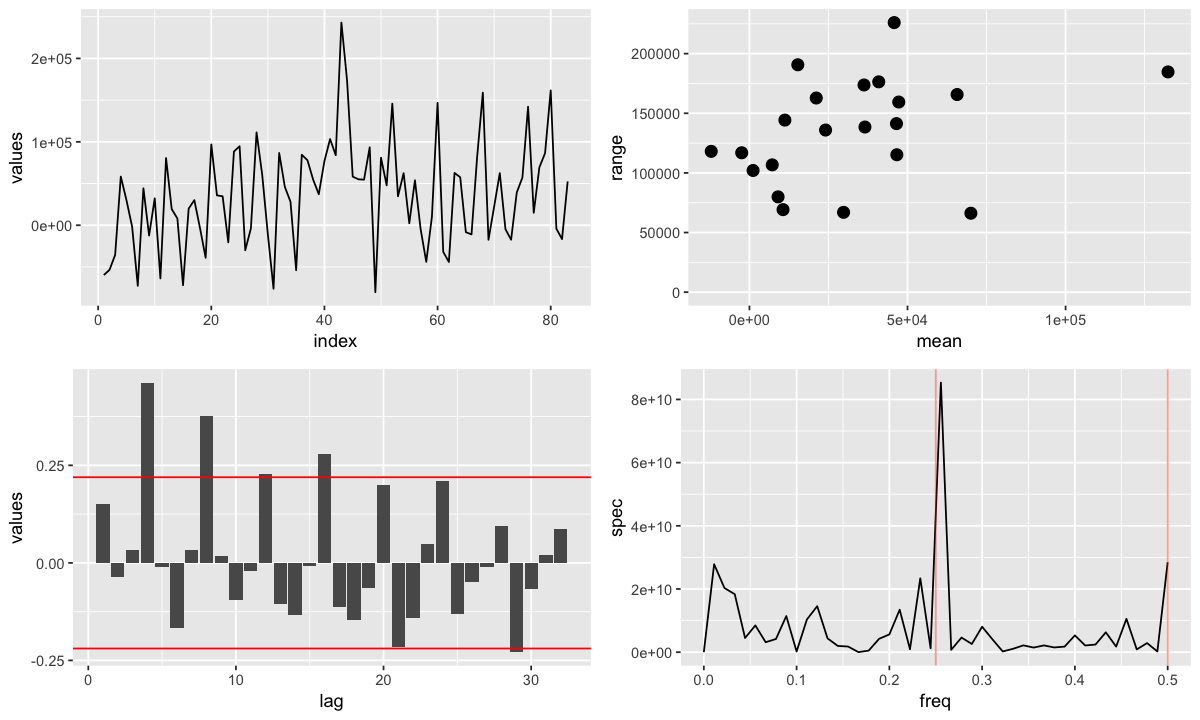

In [11]:
plot.serie(dif_1(activos$values), stationality = 4, armonics = 1:2/4)

En las figuras superiores se muestran el gráfico de la serie, el diagrama de dispersión *rango-media*, el correlograma y el periodograma respectivamente. Por tanto, a continuación procederemos a dar una interpretación a los mismos.

Al observar el grafico de la serie diferenciada podría pensarse que es ruido blanco por la aparente aleatoriedad de las observaciones. Sin embargo, observamos un salto en la zona intermedia, así como una ligera tendencia creciente. Dicho salto podría deberse a un outlier, por lo sería interesante hacer un análisis complementario de la serie obviando dicha observación. Sin embargo, en este caso únicamente nos hemos centrado en estudiar la razón del mismo: Se puede comprobar que la observación se corresponde con el segundo trimestre de $1987$. En dicho año, hubo un cambio en la legislación sobre las condiciones de trabajo y participación de personal en actividades públicas, recogida en el BOE en este articulo: https://www.boe.es/buscar/pdf/1987/BOE-A-1987-14115-consolidado.pdf


En cuanto al diagrama de dispersión *rango-media* seguimos apreciando una distribución uniforme de los pares, lo cual nos hace pensar que no existe correlación entre media y varianza, algo que es deseable en el análisis de series (y que sino deberíamos tratar de corregir con transformaciones).

En cuanto al correlograma, ahora si que se ve una marcada estacionalidad al estudiar el correlograma de la serie, observando correlaciones periódicas de periodo 4, que decrecen de manera lineal. Esto nos indica que la serie presenta una estacionalidad de periodo $4$, por tanto, posteriormente diferenciaremos la serie respecto de este retardo para conseguir desestacionarla completamente. Esta serie no es estacionaria debido a la componente estacional.

En cuanto al periodograma, se puede apreciar que el armónico $\frac{1}{4}$ destaca claramente respecto del resto, lo cual se ve reflejado en el armónico $\frac{1}{2}$. Esto confirma que la serie presenta una tendencia de periodo $4$. En cuanto al tipo de periodo de esta serie, se cree que es de tipo determinista, ya que se observan los armónicos significativos muy marcados en valores concretos. En caso contrario, diríamos que es estocástica.

* Diferenciación Estacional (periodo 4)

\begin{align*}
  \nabla_{4} X_t 
  &= (1 - B^{4}) X_t \\
  &= X_t - X_{t-4}
\end{align*}

In [12]:
dif_4 <- function(x) {
    d <- diff(x, lag = 4)
    data.frame(index = 1:length(d), values = d)
}

A continuación se muestran distintos gráficos de la serie diferenciada respecto del cuarto retardo, es decir, $\nabla X_t$. Estos gráficos se corresponden con el gráfico de la serie, el gráfico de dispersión *rango-media*, el correlograma y el periodograma. A continuación se trata de dar una interpretación acerca de los mismos.

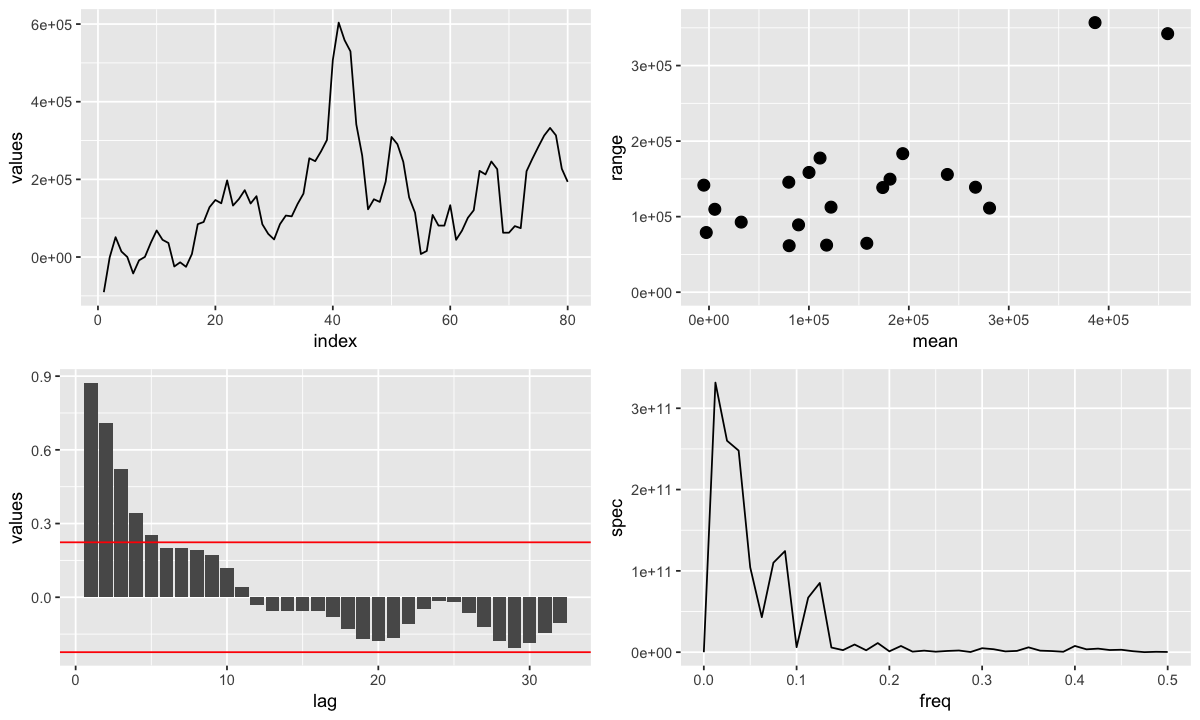

In [13]:
activos.dif_4 <- dif_4(activos$values)
plot.serie(activos.dif_4, stationality = 4)

En el gráfico de la serie se puede observar que esta presenta tendencia creciente, que no podemos considerar como ruido blanco (a continuación se da una justificación). Se sigue observando un pico en el grafico pero esta vez no es debido a una sola observación, sino que son cuatro las implicadas (correspondientes a un ciclo anual).

En cuanto al correlograma, en este se puede apreciar un decrecimiento rápido (de carácter exponencial) en las autocorrelaciones. Esto indica por tanto que hemos conseguido llegar a la estacionaridad de la serie.

Esto se ve reflejado en el periodograma, ya que se observa un alto valor en la primera frecuencia de Fourier. La interpretación de esto es que el armónico $1/n$ explica mucha variabilidad.

## Ajustar una curva por mínimos cuadrados a la serie desestacionalizada para modelizar la tendencia. Representar la ACF y periodograma de los residuales y comentar lo que se observa en los gráficos.

Para el ajuste de la serie por mínimos cuadrados, se ha escogido, un modelo lineal polinómico de grado $3$:
$$E\left[Y\right] = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3$$

Sin embargo, tal y como se puede apreciar en el siguiente gráfico, en el que se muestra la estimación sobre los datos observados, este no consigue recoger gran parte de la variabilidad de la serie. 

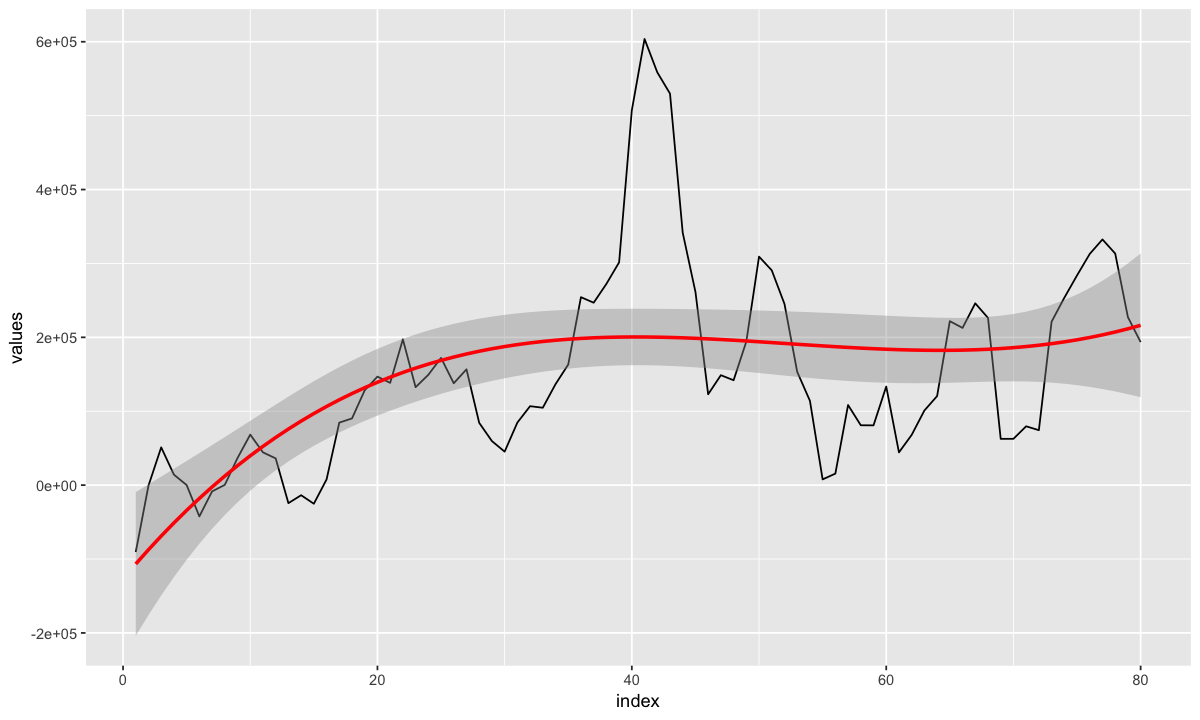

In [14]:
ggplot(activos.dif_4) + 
    aes(x = index, y = values) + 
    geom_line() + 
    geom_smooth(method="lm", formula=y ~ poly(x, 3), level = 0.95, color = "red")

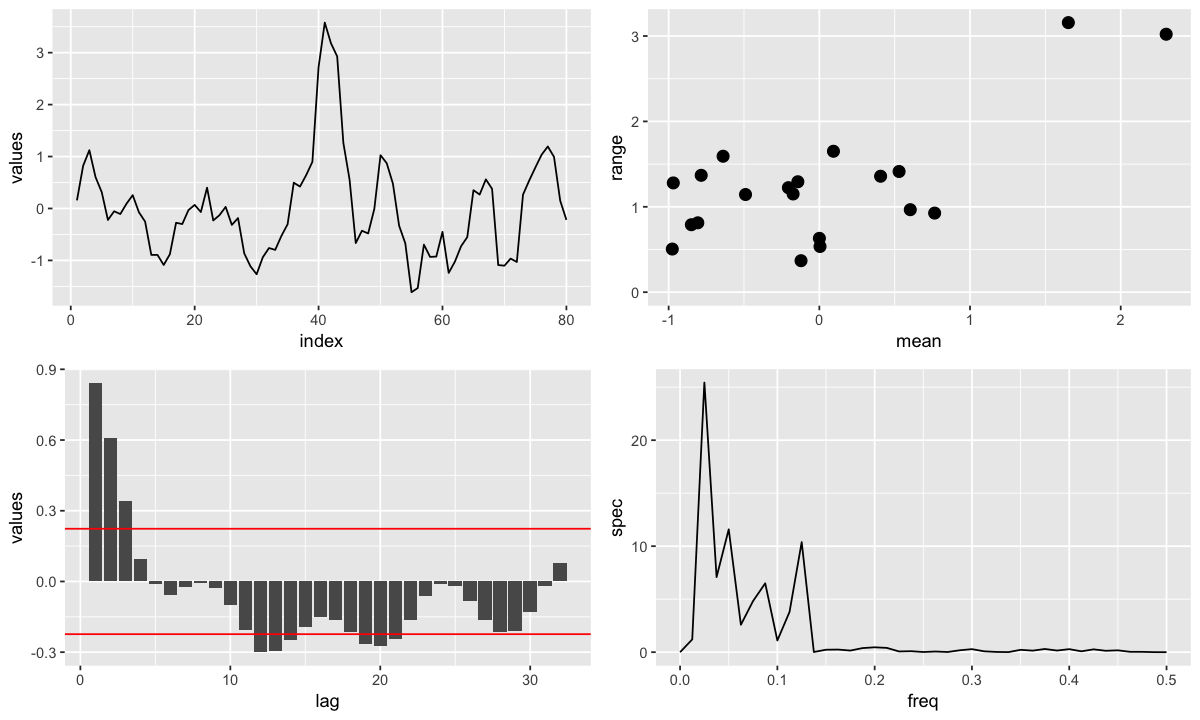

In [15]:
activos.dif_4.model <- lm(values ~ poly(index, 3), data = activos.dif_4)
activos.dif_4.model.p <- activos.dif_4
activos.dif_4.model.p$values <- rstandard(activos.dif_4.model)
plot.serie(activos.dif_4.model.p, stationality = 4)

En el correlograma se puede apreciar que los residuales de la serie tienen estacionalidad, dada la elevada autocorrelación entre observaciones distantes 4 retardos (período de la serie), de modo que esta no ha podido explicarse completamente con el ajuste de mínimos cuadrados. Se confirma atendiendo al periodograma, que muestra la elevada varianza recogida por la frecuencia $\frac{1}{4}$.

## Utilizar medias móviles de distintos órdenes para suavizar la serie y comentar el efecto.

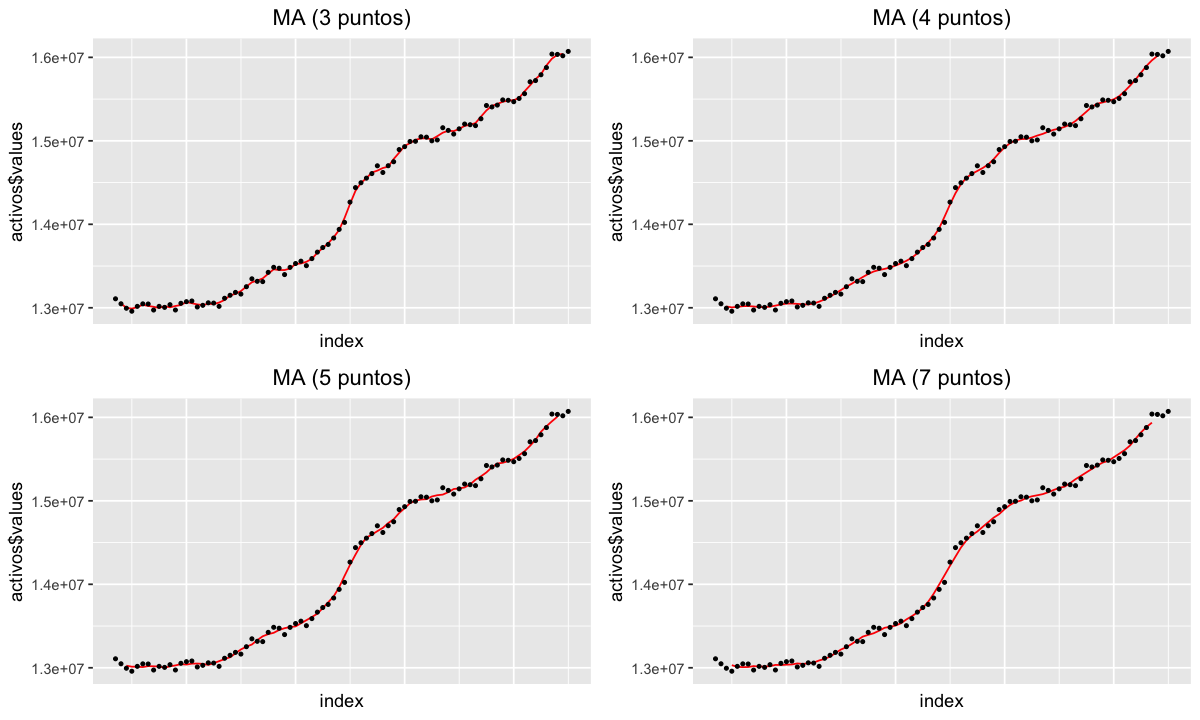

In [16]:
p.a <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,3))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (3 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

p.b <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,4))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (4 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

p.c <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,5))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (5 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

p.d <- ggplot(activos, aes(x = index, y = activos$values)) +
    geom_line(aes(y = as.vector(ma(activos$values,7))), 
              na.rm=TRUE, color = "red") +
    geom_point(size = 0.75) +
    ggtitle("MA (7 puntos)") +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

cowplot::plot_grid(p.a, p.b, p.c, p.d)

Se probaron medias móviles de 3, 4, 5 y 7 puntos. Tal y como se aprecia en el gráfico, cuanto mayor es el número de puntos de la media móvile, más fácil es apreciar la suavizacion sobre la misma. Para 3 puntos, el suavizado es leve, mientras que para 7, este es muy marcado, eliminando casi por completo la estacionalidad.

## Obtener la descomposición clásica en tendencia y estacionalidad. Dar una valoración de la componente estacional.

En este caso, se ha utilizado una descomposición de carácter aditivo sobre la serie, tal y como se muestra a continuación:

In [17]:
decomposeAndSplit <- function(input.data, frequency, type) {
    d <- decompose(ts(input.data$values, frequency = frequency), type = type)
    output.data <- data.frame(time = 1:nrow(activos),
                              seasonal = d$seasonal, 
                              trend = d$trend, 
                              random = d$random)
    output.data <- melt(output.data ,id.vars = 'time', 
                        variable.name = 'series')
    return(output.data)
}

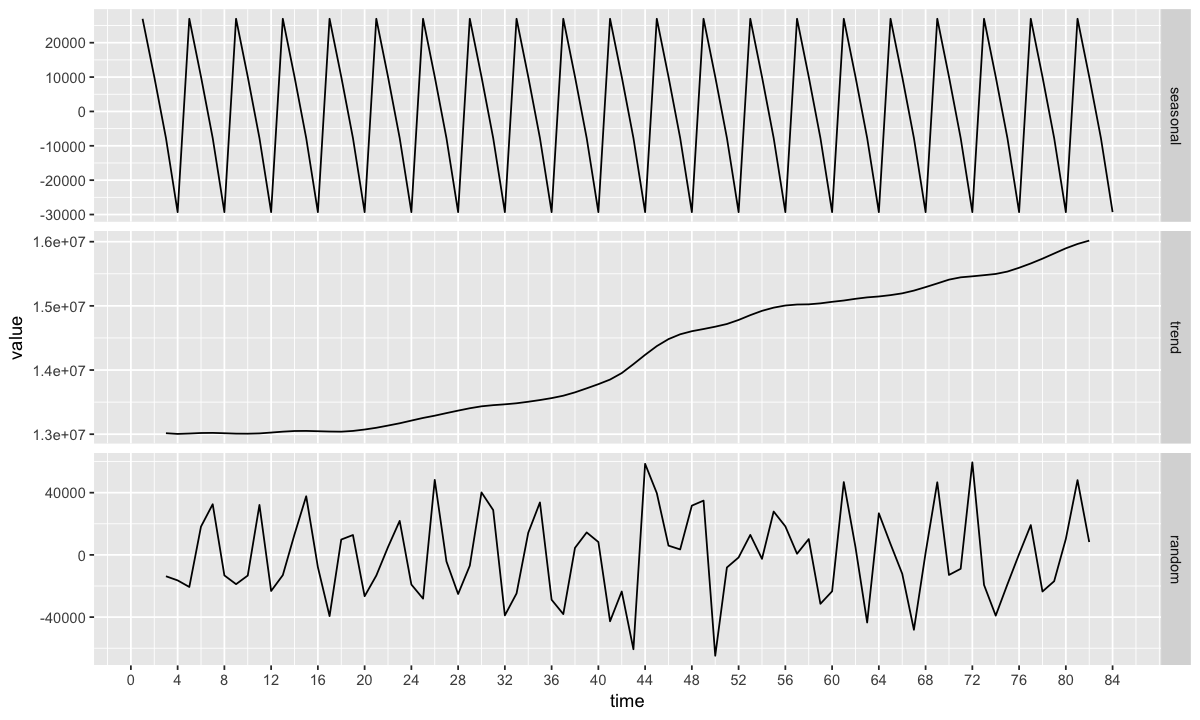

In [18]:
activos.additive <- decomposeAndSplit(activos, frequency = 4, type = "additive")

activos.additive %>%
    ggplot(aes(time,value)) + 
        geom_line(na.rm = TRUE) + 
        scale_x_continuous(breaks = seq(0, 84, by = 4)) +
        facet_grid(series ~ ., scales="free_y")

Tal y como se aprecia en el gráfico las cuatro componentes estacionales (cuatro trimestres) tienen el mismo valor. En el gráfico se observa la repetición de un mismo patrón a lo largo de cada período.

Se ha escogido un modelo aditivo frente al multiplicativo por sencillez, ya que la descomposición que este proporciona respecto del multiplicativo es muy similar, no sabiendo cual de las dos opciones sería más apropiada para esta serie.